In [1]:
try:
    from google.colab import drive
except ModuleNotFoundError:
    IN_COLAB = False
else:
    drive.mount('/content/drive')
    IN_COLAB = True

In [2]:
if IN_COLAB:
    REF_PATH = "/content/drive/MyDrive/Project/"
else:
    REF_PATH = "../../data/"
REF_PATH += "Average pm25 per neighborhood BASELINE.csv"

In [3]:
TRIPS_PATH = 'https://raw.githubusercontent.com/IsamAljawarneh/datasets/1c2a6af7dea7aa93105ac1d1d0118d07bd681d8a/data/NYC_Pilot2_PM_Part1.csv'
POLYGON_PATH = 'https://raw.githubusercontent.com/IsamAljawarneh/datasets/1c2a6af7dea7aa93105ac1d1d0118d07bd681d8a/data/nyc_polygon.geojson'

In [4]:
import pandas as pd
import folium
import geopandas as gpd
from datetime import datetime
import numpy as np
from shapely.geometry import Polygon
import math
import matplotlib.pyplot as plt
from shapely import wkt

from s2 import s2

In [5]:
s2_resolution_min = 0
s2_resolution_max = 30
sampling_frequency = 0.6

In [6]:
trips = pd.read_csv(TRIPS_PATH)
# Filter trips with corresponding neighborhoods in NYC
trips = gpd.sjoin(
    gpd.GeoDataFrame(trips, geometry=gpd.points_from_xy(trips.longitude, trips.latitude), crs='epsg:4326'),
    gpd.read_file(POLYGON_PATH)
)[list(trips.columns) + ["neighborhood"]]

In [7]:
reference_value = pd.read_csv(REF_PATH)
reference_value['geometry'] = reference_value['geometry'].apply(wkt.loads)
reference_value = gpd.GeoDataFrame(reference_value, crs='epsg:4326')
print(reference_value['neighborhood'].nunique())
print(len(reference_value['neighborhood']))

48
48


In [8]:
def calculate_rmse(predicted_values, actual_values):
    # Calculate squared differences
    squared_diff = (predicted_values - actual_values) ** 2
    
    # Calculate mean squared differences
    mean_squared_diff = np.mean(squared_diff)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_diff)
    
    return rmse

In [9]:
def group_by_s2(df, s2_resolution):
    df['s2'] = df.apply(lambda x: s2.geo_to_s2(x.latitude, x.longitude, s2_resolution), axis=1)
    return df.groupby('s2')

In [10]:
def get_rmse_s2(baseline, encoded):
    error = []
    s2_resolution = s2_resolution_min
    while s2_resolution <= s2_resolution_max:
        sampled_trips = group_by_s2(encoded, s2_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True) #Stratified Sampling
        df_enc_pm25 = (sampled_trips
                          .groupby('s2')
                          .pm25
                          .agg(list)
                          .to_frame("pm25_list")
                          .reset_index())  # Make a list of pm25 values for each s2 cell
        df_enc_pm25['average_pm25_value'] = df_enc_pm25['pm25_list'].apply(lambda x:sum(x)/len(x)) #Find the average pm25 value for each s2 cell
        df_enc_pm25.drop('pm25_list', axis = 1, inplace=True)
        sampled_trips_with_neighborhood_pm25 = pd.merge(sampled_trips, baseline, on='neighborhood', how='inner')
        sampled_trips_with_enc_geometry_pm25 = pd.merge(sampled_trips, df_enc_pm25, on='s2', how='inner')
        assert sampled_trips_with_neighborhood_pm25.shape[0] == sampled_trips_with_enc_geometry_pm25.shape[0]
        columns = list(sampled_trips.columns)
        sampled_trips_with_neighborhood_pm25.sort_values(by=columns, inplace=True)
        sampled_trips_with_neighborhood_pm25.reset_index(drop=True, inplace=True)
        sampled_trips_with_enc_geometry_pm25.sort_values(by=columns, inplace=True)
        sampled_trips_with_enc_geometry_pm25.reset_index(drop=True, inplace=True)
        baseline_pm25 = sampled_trips_with_neighborhood_pm25["average_pm25_value"].values
        sampled_pm25  = sampled_trips_with_enc_geometry_pm25["average_pm25_value"].values
        rmse = calculate_rmse(sampled_pm25, baseline_pm25)
        error.append(rmse) #Append to Error list
        s2_resolution += 1
    return error

In [11]:
RMSE_S2 = get_rmse_s2(reference_value,trips)

In [12]:
RMSE_S2

[0.4128590373911514,
 0.4088648440748168,
 0.403014451307627,
 0.40753013866800536,
 0.41154584954339063,
 0.4111172941768245,
 0.4057986865158078,
 0.3131358184031176,
 0.32325971237553963,
 0.31396762816459683,
 0.3092759382251249,
 0.3029662204613638,
 0.2677507313583058,
 0.2760927249939788,
 0.2726855729494772,
 0.4355384459387119,
 0.6138044181574612,
 0.7808898415692686,
 0.9271242988638974,
 1.1151427296425616,
 1.3231211531900655,
 1.4897680176744033,
 1.597644658324675,
 1.6603962781101484,
 1.6965423675062363,
 1.7033905244903975,
 1.7033977306073143,
 1.705887255067152,
 1.7062083057093522,
 1.7065668971652561,
 1.7052089575184615]

<Figure size 640x480 with 0 Axes>

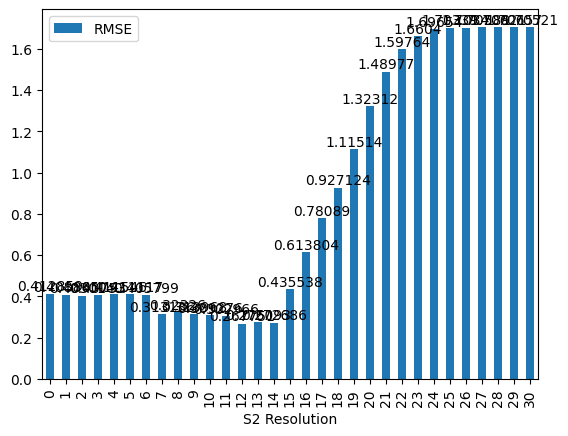

In [13]:
X_LABEL = 'S2 Resolution'
Y_LABEL = 'RMSE'
S2_Performance = pd.DataFrame({X_LABEL:list(range(s2_resolution_min, s2_resolution_max + 1)),
                               Y_LABEL: RMSE_S2})
plt.figure()
ax = S2_Performance.plot(kind='bar', x=X_LABEL, y=Y_LABEL)
ax.bar_label(ax.containers[0], color = 'black')
plt.show()